In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
import warnings
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

In [90]:
# Load the CSV file
df = pd.read_csv('ecom_shipping_data.csv')
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# Data cleaning

#### We don't need the ID columns since we are using the DataFrame index instead, so let's drop them.

In [91]:
# dropping unwanted column
df.drop('ID', axis = 1, inplace = True)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1


#### Check if there are any missing or null values in the dataset.

In [92]:
# Check for null or missing values
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64


#### There are no missing or null values in the dataset. Next, we proceed with statistical analysis.

# Statistical analysis

In [93]:
# Descriptive statistics of the DataFrame
df.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


#### Based on the summary statistics, there are no obvious outliers in the dataset.

# Visualization

#### I'm visualizing the data in our dataset to see the characteristics of each categorical column. I will create bar charts to show the counts of each category, to help us understand the distribution of values in these columns.

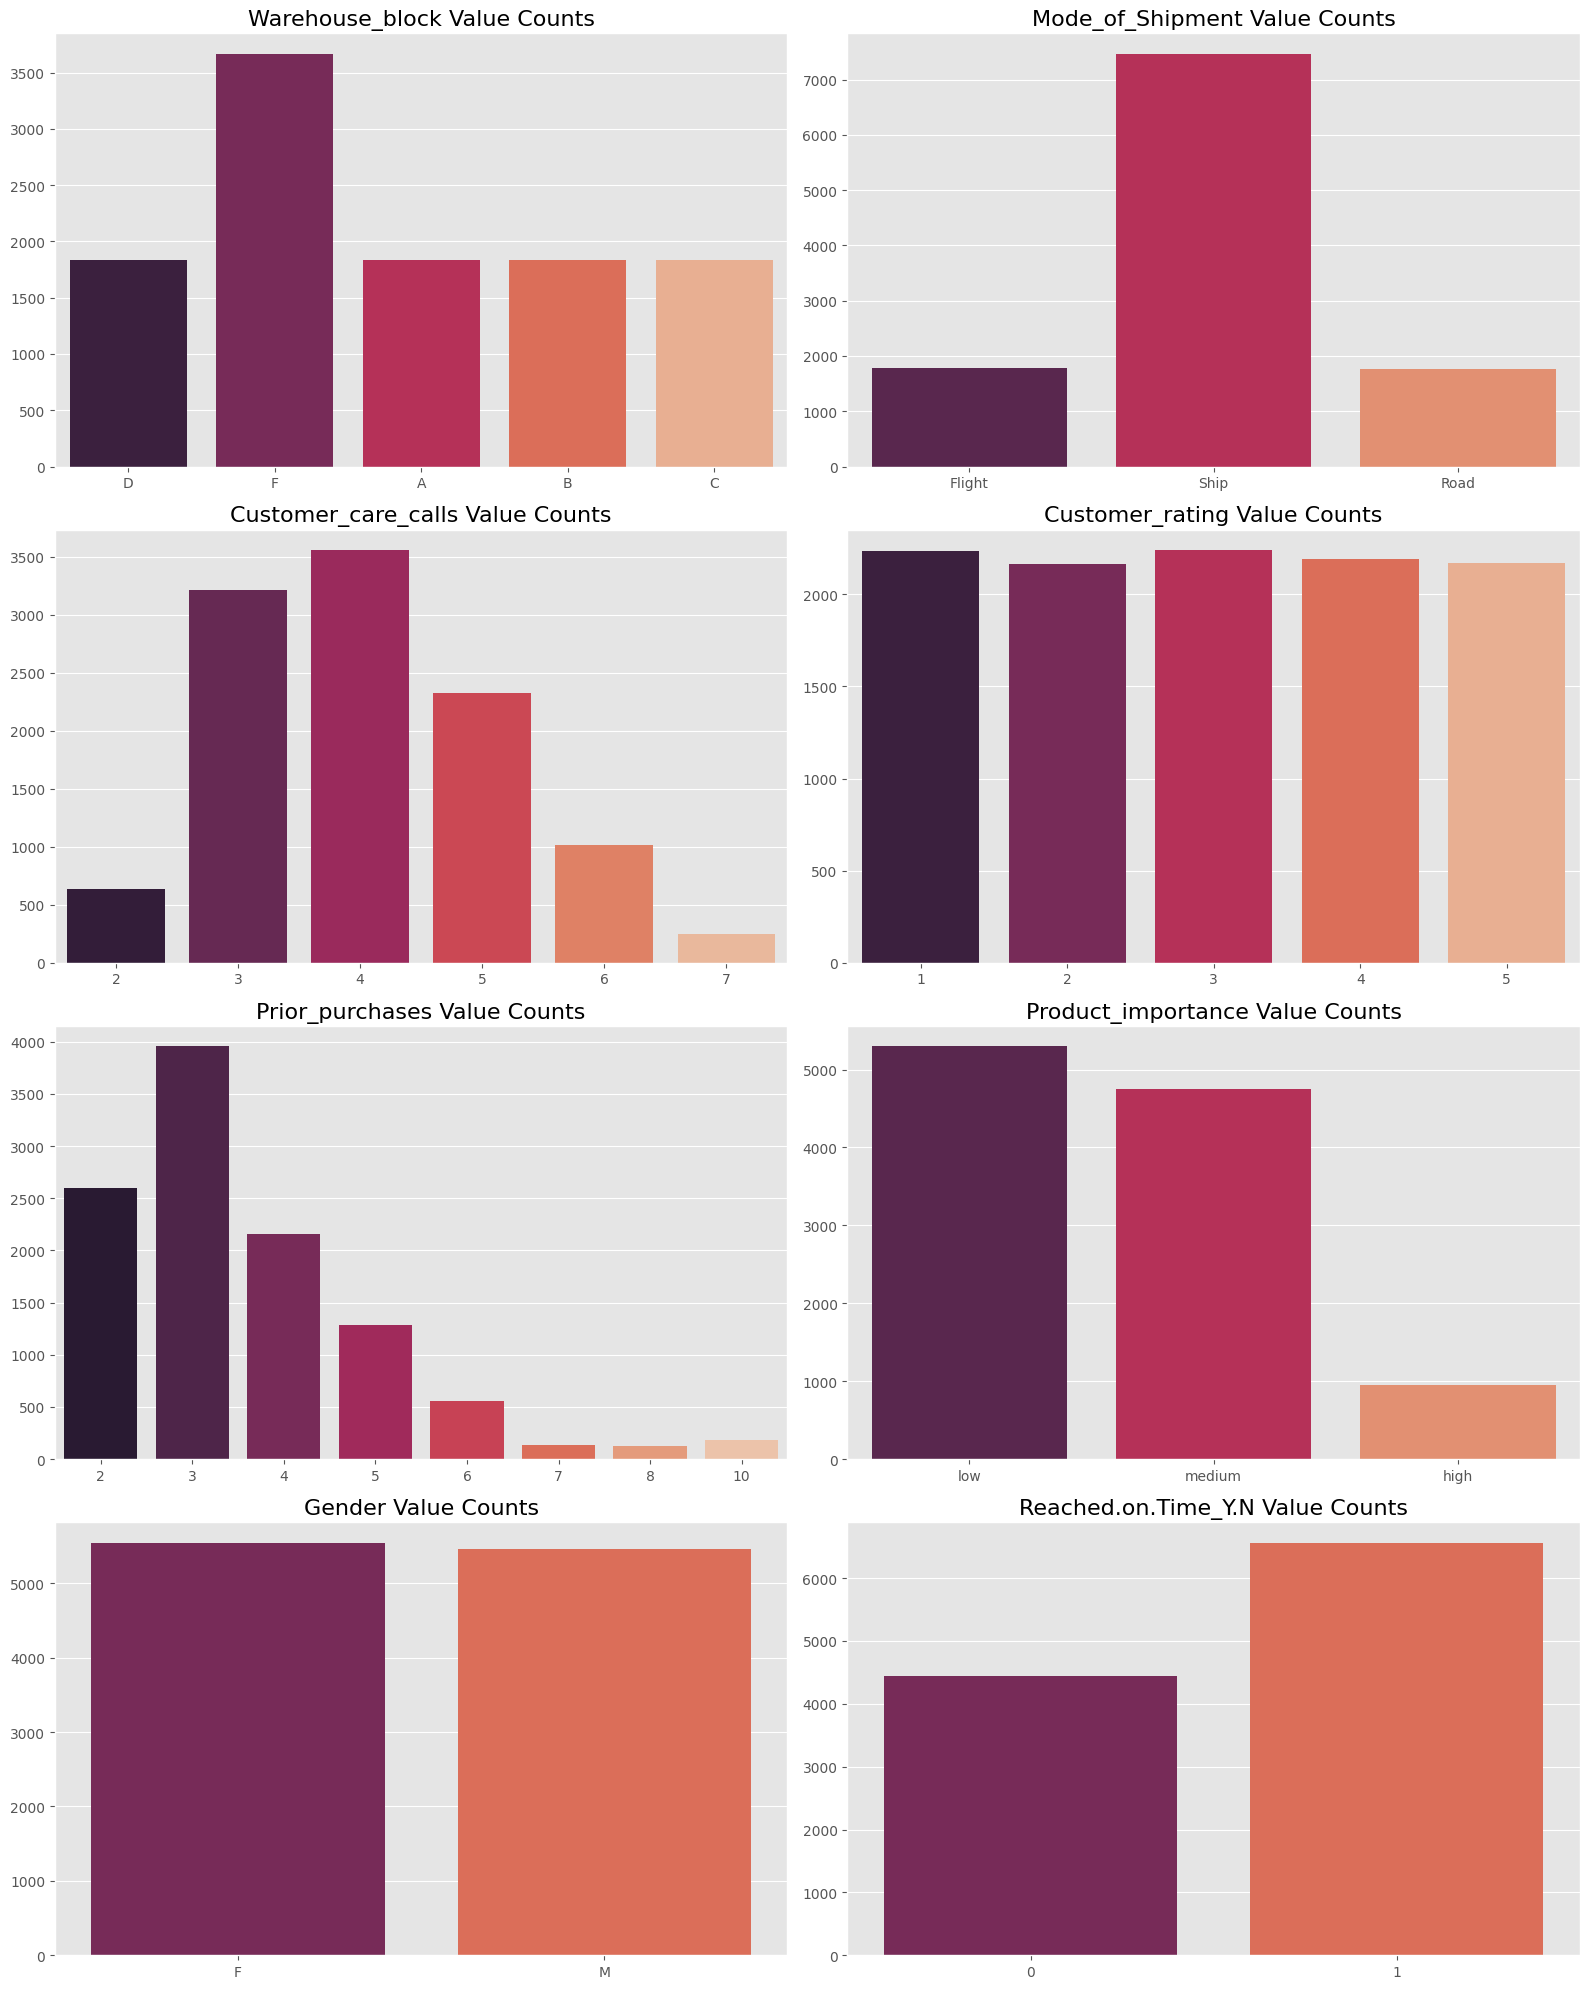

In [94]:
# Visualizing the counts of each category in the categorical columns
categorical_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls', 'Customer_rating',
                       'Prior_purchases', 'Product_importance', 'Gender', 'Reached.on.Time_Y.N']

# Set the size of the figure
plt.figure(figsize=(16, 20))

# Loop through each categorical column and plot the count plot
for idx, col in enumerate(categorical_columns, start=1):
    ax = plt.subplot(4, 2, idx)
    sns.countplot(x=col, data=df, palette='rocket', ax=ax)
    ax.set_title(f"{col} Value Counts", fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

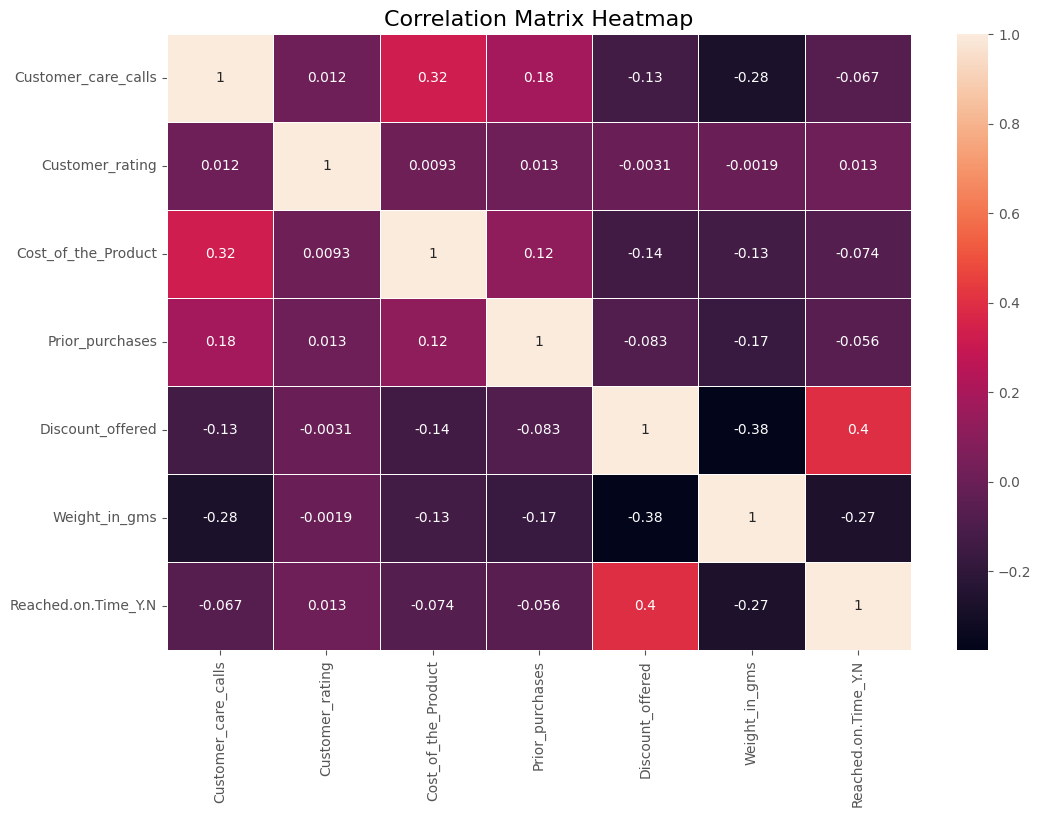

In [95]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='rocket', linewidths=.5, annot_kws={"size": 10})

# Add title
plt.title('Correlation Matrix Heatmap', fontsize=16)

# Display the plot
plt.show()

In [96]:
# Map the values in the 'Reached.on.Time_Y.N' column to more descriptive labels and calculate value counts
reached_on_time_y_n = (
    df['Reached.on.Time_Y.N']
    .map({1: 'Not Reached on Time', 0: 'Reached on Time'})
    .value_counts().reset_index()
)

In [97]:
reached_on_time_y_n

,Reached.on.Time_Y.N,count
0,Not Reached on Time,6563
1,Reached on Time,4436


In [98]:
reached_on_time_y_n.columns = ['Reached.on.Time_Y.N', 'value_counts']

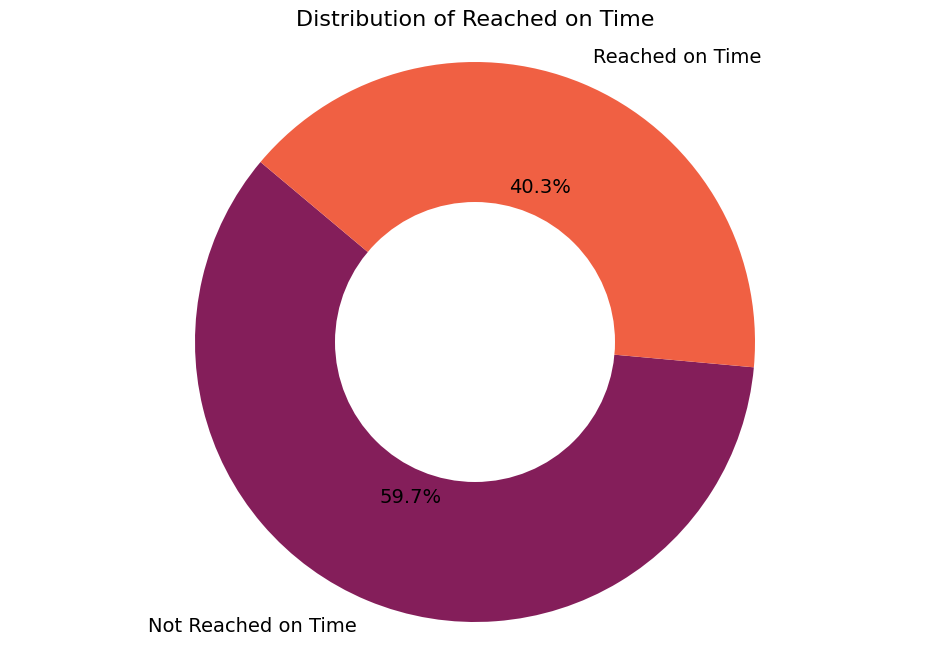

In [99]:
# Define colors
colors = sns.color_palette('rocket', len(reached_on_time_y_n))

# Create the donut chart
plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(
    reached_on_time_y_n['value_counts'], 
    labels=reached_on_time_y_n['Reached.on.Time_Y.N'], 
    colors=colors,
    autopct='%1.1f%%', 
    startangle=140, 
    textprops={'fontsize': 14, 'color': 'black'}
)

# Add a circle in the center to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add title
plt.title('Distribution of Reached on Time', fontsize=16)

# Ensure that pie is drawn as a circle.
plt.axis('equal')

# Display the plot
plt.show()

# Data Preprocessing: Encoding Categorical Variables

In [100]:
# Encode categorical variables
label_encoders = {}
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le

In [101]:
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,3,0,4,2,177,3,1,0,44,1233,1
1,4,0,4,5,216,2,1,1,59,3088,1
2,0,0,2,2,183,4,1,1,48,3374,1
3,1,0,3,3,176,4,2,1,10,1177,1
4,2,0,2,2,184,3,2,0,46,2484,1


# Data Preprocessing: Scaling Features

In [102]:
X = df.drop(['Reached.on.Time_Y.N'], axis=1)
y = df['Reached.on.Time_Y.N']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_scaled.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,0.447189,-2.004158,-0.047711,-0.700755,-0.690722,-0.372735,-0.548034,-0.991760,1.889983,-1.468240
1,1.118034,-2.004158,-0.047711,1.421578,0.120746,-1.029424,-0.548034,1.008308,2.815636,-0.333893
2,-1.565345,-2.004158,-1.799887,-0.700755,-0.565881,0.283954,-0.548034,1.008308,2.136824,-0.159002
3,-0.894500,-2.004158,-0.923799,0.006689,-0.711529,0.283954,1.035735,1.008308,-0.208162,-1.502484
4,-0.223656,-2.004158,-1.799887,-0.700755,-0.545074,-0.372735,1.035735,-0.991760,2.013404,-0.703244


# Dealing with Imbalanced Data

#### In the dataset, the Reached.on.Time_Y.N column shows a 40.3% on-time rate and a 59.7% not-on-time rate, indicating an imbalance. Addressing this imbalance is crucial to ensure that the model doesn't become biased towards the majority class (not on time).

#### I will use SMOTE to address the imbalance issue in the dataset.

In [103]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'Original dataset shape: {y_train.value_counts()}')
print(f"#"*30)
print(f'Resampled dataset shape: {y_train_resampled.value_counts()}')

Original dataset shape: Reached.on.Time_Y.N
1    5258
0    3541
Name: count, dtype: int64
##############################
Resampled dataset shape: Reached.on.Time_Y.N
0    5258
1    5258
Name: count, dtype: int64


#### After applying SMOTE, the dataset is now balanced with a 50:50 distribution in the Reached.on.Time_Y.N column. This ensures that there are an equal number of samples for both the "Reached on Time" and "Not Reached on Time" classes, which helps to improve the model's ability to learn and predict both classes more accurately.

# Model training and evaluation

#### I selected five algorithms: DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, and LogisticRegression. These algorithms were used to train our resampled training set.

#### I chose the F1 score to evaluate model performance because it provides a balanced measure of precision and recall, which is crucial for handling imbalanced data. Unlike accuracy, which can be misleading in such scenarios, the F1 score considers both false positives and false negatives. This ensures that our models accurately identify both on-time and delayed deliveries, leading to more reliable and effective predictions.

### DecisionTreeClassifier

In [104]:
# Initialize DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = dt.predict(X_test)

# Calculate the F1 score of the model
dt_f1_score_value = f1_score(y_test, y_pred)

print(f"#"*30)
print(f"DecisionTreeClassifier F1 score: {dt_f1_score_value:.4f}")
print(f"#"*30)
print(f"\n")

print(classification_report(y_test,y_pred))

##############################
DecisionTreeClassifier F1 score: 0.7098
##############################


              precision    recall  f1-score   support

           0       0.58      0.63      0.61       895
           1       0.73      0.69      0.71      1305

    accuracy                           0.67      2200
   macro avg       0.66      0.66      0.66      2200
weighted avg       0.67      0.67      0.67      2200



### RandomForestClassifier

In [105]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Calculate the f1_score of the model
rf_f1_score_value = f1_score(y_test, y_pred)

print(f"#"*30)
print(f"RandomForestClassifier F1 score: {rf_f1_score_value:.4f}")
print(f"#"*30)
print(f"\n")

print(classification_report(y_test,y_pred))

##############################
RandomForestClassifier F1 score: 0.6903
##############################


              precision    recall  f1-score   support

           0       0.58      0.81      0.67       895
           1       0.82      0.60      0.69      1305

    accuracy                           0.68      2200
   macro avg       0.70      0.70      0.68      2200
weighted avg       0.72      0.68      0.68      2200



### GradientBoostingClassifier

In [106]:
gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X_train_resampled, y_train_resampled)

y_pred = gbc.predict(X_test)

# Calculate the f1_score of the model on the training and testing sets
gbc_f1_score_value = f1_score(y_test, y_pred)

print(f"#"*30)
print(f"GradientBoostingClassifier F1 score: {gbc_f1_score_value:.4f}")
print(f"#"*30)
print(f"\n")

print(classification_report(y_test,y_pred))

##############################
GradientBoostingClassifier F1 score: 0.6744
##############################


              precision    recall  f1-score   support

           0       0.58      0.93      0.71       895
           1       0.91      0.53      0.67      1305

    accuracy                           0.69      2200
   macro avg       0.75      0.73      0.69      2200
weighted avg       0.78      0.69      0.69      2200



F1 score is the harmonic mean of precision and recall, so it is more comprehensive than considering precision or recall alone when considering the performance of a classifier. This bar chart clearly shows how F1 score finds a balance between precision and recall.

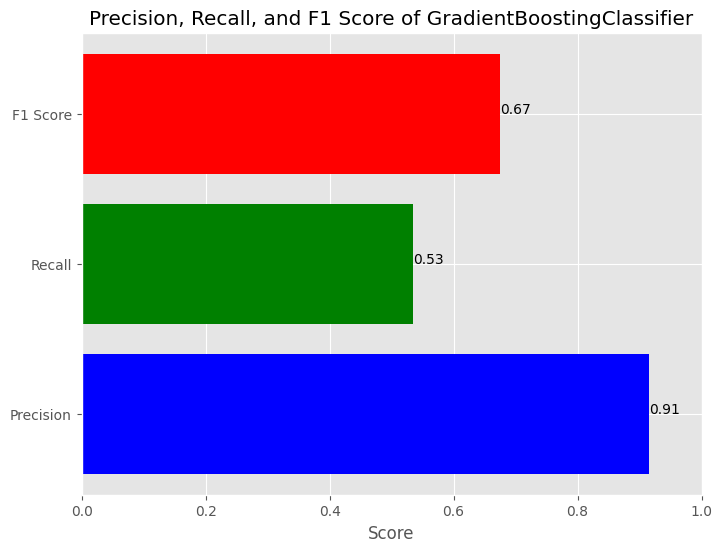

In [108]:
# Get report data
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = gbc_f1_score_value


# Visualizing Precision, Recall, and F1 Score
metrics = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.barh(metrics, scores, color=['blue', 'green', 'red'])
plt.xlim(0, 1)
for index, value in enumerate(scores):
    plt.text(value, index, f'{value:.2f}')
plt.xlabel('Score')
plt.title('Precision, Recall, and F1 Score of GradientBoostingClassifier')
plt.show()

### AdaBoostClassifier

In [109]:
# Initialize AdaBoostClassifier
abc = AdaBoostClassifier(random_state=42)

# Fit the model on the training data
abc.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = dt.predict(X_test)

# Calculate the f1_score of the model
ada_f1_score_value = f1_score(y_test, y_pred)

print(f"#"*30)
print(f"AdaBoostClassifier F1 score: {ada_f1_score_value:.4f}")
print(f"#"*30)
print(f"\n")

print(classification_report(y_test,y_pred))

##############################
AdaBoostClassifier F1 score: 0.7098
##############################


              precision    recall  f1-score   support

           0       0.58      0.63      0.61       895
           1       0.73      0.69      0.71      1305

    accuracy                           0.67      2200
   macro avg       0.66      0.66      0.66      2200
weighted avg       0.67      0.67      0.67      2200



### LogisticRegression

In [110]:
# Initialize LogisticRegression
lr = LogisticRegression(random_state=42)

# Fit the model on the training data
lr.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = lr.predict(X_test)

# Calculate the f1_score of the model
lr_f1_score_value = f1_score(y_test, y_pred)

print("#" * 30)
print(f"LogisticRegression F1 score: {lr_f1_score_value:.4f}")
print("#" * 30)
print("\n")

print(classification_report(y_test, y_pred))

##############################
LogisticRegression F1 score: 0.6509
##############################


              precision    recall  f1-score   support

           0       0.55      0.80      0.65       895
           1       0.80      0.55      0.65      1305

    accuracy                           0.65      2200
   macro avg       0.68      0.68      0.65      2200
weighted avg       0.70      0.65      0.65      2200



### SVC

In [111]:
# Initialize SVC
svc = SVC(random_state=42)

# Fit the model on the training data
svc.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = svc.predict(X_test)

# Calculate the f1_score of the model
svc_f1_score_value = f1_score(y_test, y_pred)

print("#" * 30)
print(f"SVC F1 score: {svc_f1_score_value:.4f}")
print("#" * 30)
print("\n")

print(classification_report(y_test, y_pred))

##############################
SVC F1 score: 0.6967
##############################


              precision    recall  f1-score   support

           0       0.58      0.78      0.67       895
           1       0.80      0.62      0.70      1305

    accuracy                           0.68      2200
   macro avg       0.69      0.70      0.68      2200
weighted avg       0.71      0.68      0.68      2200



### Stacking
### Stacking is an ensemble learning method that combines the prediction results of multiple different base classifiers to train a secondary classifier (also called a meta-classifier or stacked classifier) ​​to make the final prediction. The purpose of stacking is to take advantage of multiple classifiers and improve the prediction performance and generalization ability of the overall model.

In [113]:
# define base learners
base_learners = [
    ('abc', AdaBoostClassifier(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('svc', SVC(random_state=42)),
    ('rf',RandomForestClassifier(random_state=42)),
    ('gbc',GradientBoostingClassifier(random_state=42))
]

# define meta learner
meta_learner = LogisticRegression(random_state=42)

# Initialize StackingClassifier
stack = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Fit the model on the training data
stack.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = stack.predict(X_test)

# Calculate the f1_score of the model
stack_f1_score_value = f1_score(y_test, y_pred)

print("#" * 30)
print(f"StackingClassifier F1 score: {stack_f1_score_value:.4f}")
print("#" * 30)
print("\n")

print(classification_report(y_test, y_pred))

##############################
StackingClassifier F1 score: 0.6862
##############################


              precision    recall  f1-score   support

           0       0.58      0.86      0.69       895
           1       0.85      0.57      0.69      1305

    accuracy                           0.69      2200
   macro avg       0.72      0.71      0.69      2200
weighted avg       0.74      0.69      0.69      2200



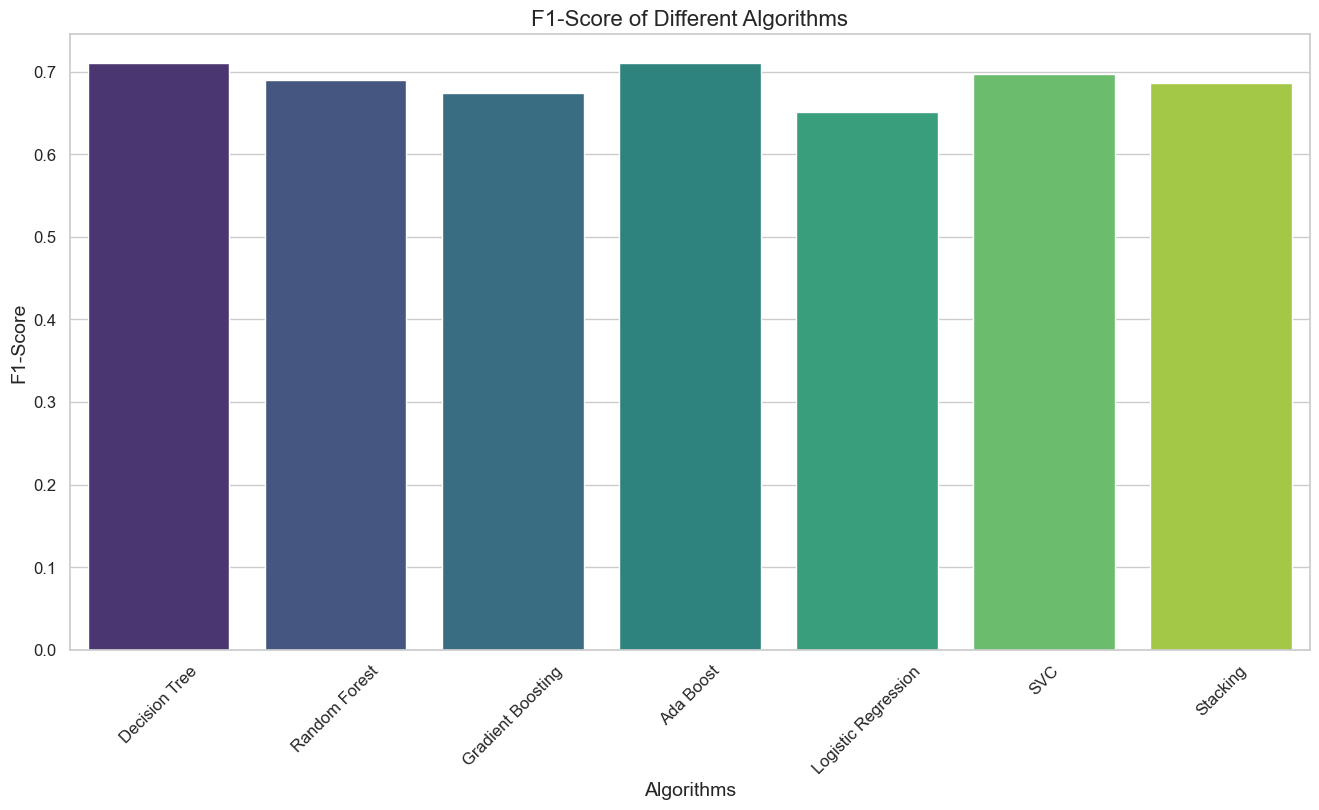

In [114]:
# Set the plotting style to 'whitegrid'
sns.set(style='whitegrid')

# Visualize F1 Scores
algos = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Ada Boost', 'Logistic Regression', 'SVC', 'Stacking']
f1_scores = [dt_f1_score_value, rf_f1_score_value, gbc_f1_score_value, ada_f1_score_value, lr_f1_score_value, svc_f1_score_value, stack_f1_score_value]

plt.figure(figsize=(16, 8))
sns.barplot(x=algos, y=f1_scores, palette='viridis')
# Add titles and labels
plt.title('F1-Score of Different Algorithms', fontsize=16)
plt.xlabel('Algorithms', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# Conclusion

#### Among the tested models, the Ada Boost Classifier and Decision Tree Classifier achieved the highest F1 score of 0.7098, indicating they performed best in balancing precision and recall. These models prove most effective for predicting on-time deliveries, offering a reliable balance in identifying both on-time and delayed shipments.

#### Although the purpose of stacking is to take advantage of multiple classifiers and improve the prediction performance and generalization ability of the overall model, we have seen that simply applying the stacking algorithm does not improve performance. The reasons may be that the performance of the base learners is similar, the meta learners are overfitted, etc., which requires more complex tuning methods.

#### An F1 score of 0.70 means that the model's performance is fairly good, balancing both precision and recall effectively:

- #### Precision: Out of all the deliveries that the model predicted to be on time, 70% were actually on time.
- #### Recall: Out of all the deliveries that were actually on time, the model correctly identified 70% of them.